In [ ]:
### Encoding model for iEEG
# Pedro Pinheiro-Chagas
# Adapted from Christopher Holdgraf's git repo: 
#(https://github.com/choldgraf/paper-encoding_decoding_electrophysiology)

In [4]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from modelingtools import delay_time_series, plot_activity_on_brain
from modelingtools import (plot_cv_indices, cross_validate_alpha)

from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn.learning_curve import learning_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, r2_score

import os
import seaborn as sns
import matplotlib.collections as clt
import ptitprince as pt

import sys
np.set_printoptions(threshold=sys.maxsize)

from sklearn import cross_validation as cv
import csv



/Users/pinheirochagas/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/pinheirochagas/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 1. The data
Task: MMR - calculation, memory verification and "rest" ('17+5=23', 'I ate fruit today'). <br/>
Type of data: epoched and baseline corrected, all concatenated. <br />
Brain feature: Normalized HFB power.  <br />

Stimuli features:
0. Task, trial, time, block
1. Task
    - condition(calculation, memory, rest) 
    - type (active, passive)
2. Calculation specs
    - number_format (digit, word, dot)
    - operand_1
    - operand_2
    - operand_min
    - operand_max
    - operation (addition, subtraction, multiplication)
    - ls_sl
    - result 
    - cross_decade
    - presented_result
    - abs_deviant
    - number of digits
3. Memory specs
    - memory type (autobio, self-external, self-internal, fact)
4. Behavior
    - RT
    - Accuracy
    - RT_lock
    
The features were already selected and the encoding matrix was consctructed in Matlab and saved as csv.

### Load the data

In [17]:
## Stim features
data = pd.read_csv('/Volumes/LBCN8T_2/Stanford/data/encoding/57_stim_features.csv') 
data.head()
#Recode task name
data.loc[data.loc[:,'task_general_cond_name']==4, 'task_general_cond_name'] = 2
data.loc[data.loc[:,'task_general_cond_name']==6, 'task_general_cond_name'] = 1

In [18]:
data.head()

,task,trial,time,block,task_general_cond_name,task_type,number_format,operand_1,operand_2,operand_min,...,cross_decade,presented_result,abs_deviant,number_of_digits,memory_type,RT,accuracy,StimulusOnsetTime,allonsets,RT_lock
0,7,1,0.000,1,1,1,0,0,0,0,...,0,0,0,0,2,3.853186,0,93429.098498,19.603467,23.456653
1,7,1,0.002,1,1,1,0,0,0,0,...,0,0,0,0,2,3.853186,0,93429.098498,19.603467,23.456653
2,7,1,0.004,1,1,1,0,0,0,0,...,0,0,0,0,2,3.853186,0,93429.098498,19.603467,23.456653
3,7,1,0.006,1,1,1,0,0,0,0,...,0,0,0,0,2,3.853186,0,93429.098498,19.603467,23.456653
4,7,1,0.008,1,1,1,0,0,0,0,...,0,0,0,0,2,3.853186,0,93429.098498,19.603467,23.456653


In [19]:
## Brain features
# Set extreme values to zero (double check spike exclusion)
#data = np.genfromtxt('/Volumes/LBCN8T_2/Stanford/data/encoding/57_brain_features.csv', delimiter=',')
#data.loc[data.loc[:,'HFB']>30, 'HFB'] = 0
y_tmp = pd.read_csv('/Volumes/LBCN8T_2/Stanford/data/encoding/57_brain_features.csv', header=None) 
y = y_tmp.to_numpy()
y[y>30]=0 # Set extreme values to 0

In [20]:
# Filter trials
good_trials = (data.loc[:,'task_general_cond_name'] == 1) | (data.loc[:,'task_general_cond_name'] == 2)
y = y[good_trials,:]
data = data.loc[good_trials,:]

### Exploratory plots

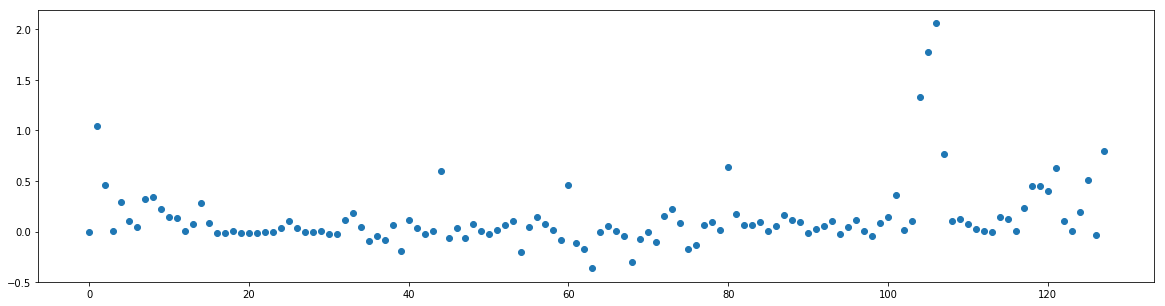

In [9]:
## Average activation electrodes
fig, ax = plt.subplots(1,1,figsize=(20, 5))
plt.scatter(np.arange(0,y.shape[1]),np.average(y, axis=0))

In [22]:
# Select an active channel
y = y[:,60]

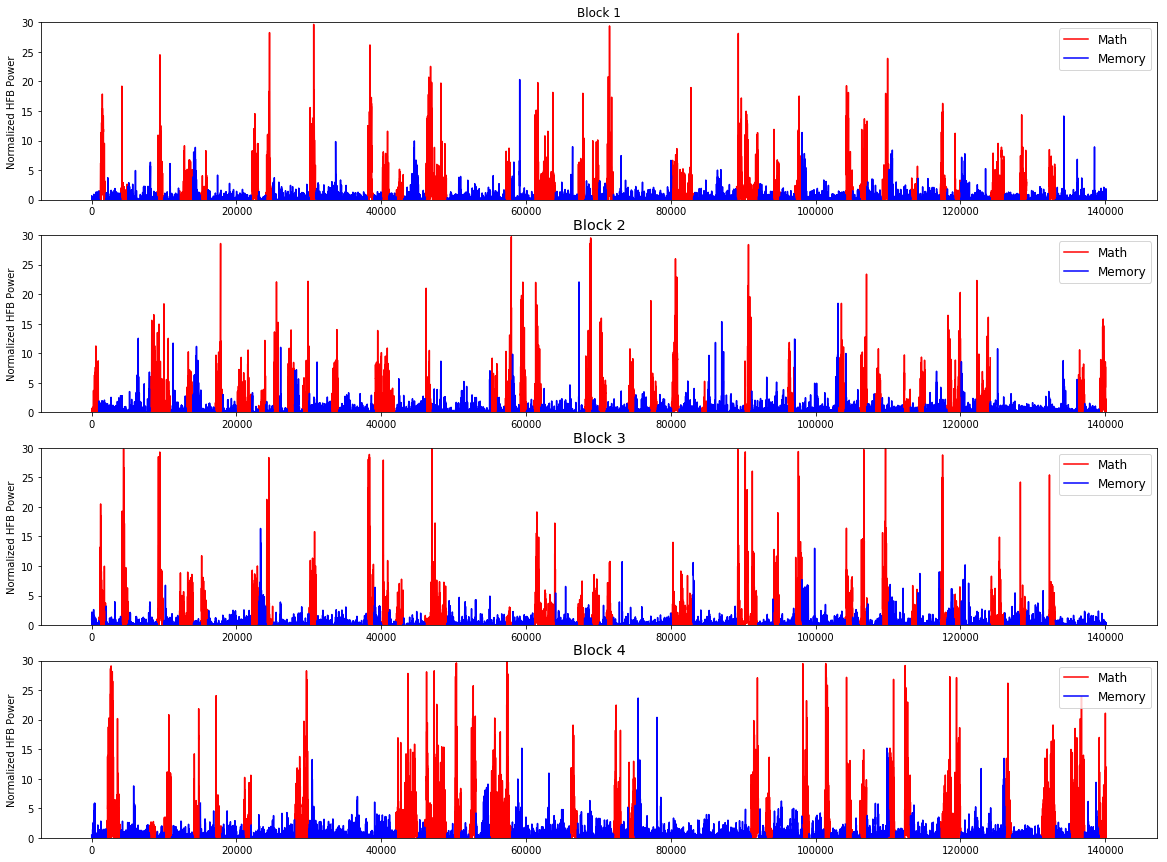

In [24]:
# Plot marked trials
n_blocks = np.int(np.max(data.loc[:,'block']))
fig, ax = plt.subplots(n_blocks,1,figsize=(20, 15))

# Filter trials
math_trials = y.copy()
math_trials[data.loc[:,'task_general_cond_name']!=2] = np.nan
memo_trials = y.copy()
memo_trials[data.loc[:,'task_general_cond_name']!=1] = np.nan

for i in range(n_blocks):
    #ax[i].plot(samples[data[:,4]==i+1], data[data[:,4]==i+1,3])
    ax[i].plot(math_trials[data.loc[:,'block']==i+1], 'r', label="Math")
    ax[i].plot(memo_trials[data.loc[:,'block']==i+1], 'b', label="Memory")
    ax[i].set_ylim([0,30])
    ax[i].set_title('Block ' + str(i+1))
    plt.rcParams.update({'font.size': 12}) 
    ax[i].set_ylabel('Normalized HFB Power')
    ax[i].legend()

In [25]:
# Define trials 
times = np.shape(np.unique(data.loc[:,'time']))
times = int(times[0])
r,c = np.shape(data)
trials = int(r/times)
trials_rs = np.matlib.repmat(np.arange(1,trials+1),times,1).T
trials_rs = trials_rs.reshape(-1,1)
data['trials'] = trials_rs

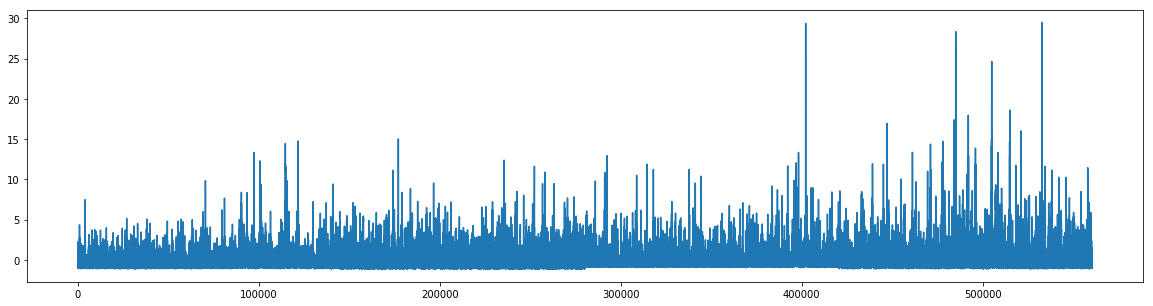

In [358]:
# Vizualize an active electrodes
fig, ax = plt.subplots(1,1,figsize=(20, 5))
ax.plot(y[:,61])

In [354]:
y.shape[1]

128

In [324]:
features = list(['task_general_cond_name', 'result'])

In [325]:
features[1]

'result'

In [26]:
X_all = np.empty((560560, 76), int)
for fi in range(1,len(features)):
    features = np.array(data.loc[:,features[fi]]) # result
    times = np.shape(np.unique(data.loc[:,'time']))
    times = int(times[0])
    r,c = np.shape(data)
    trials = int(r/times)

    # Reshape features
    features_reshape = np.reshape(features, (trials, times))
    features_reshape = np.expand_dims(features_reshape, axis=1)

    # Add delayed features
    fs = 500
    time_window = 0.02;
    #n_delays = 100
    #delays = np.linspace(1, 2, 100)

    start = 0; stop = 1.5; step = time_window
    delays = np.arange(start, stop+step, step)
    n_delays = int(len(delays))

    X_delayed = np.zeros((trials,1,n_delays,times))
    for i in range(trials):
        for ii in range(n_delays):
            window = [int(np.round(delays[ii]*fs)),int(np.round((delays[ii]+time_window)*fs))]
            X_delayed[i,0,ii,window[0]:window[1]] = int(np.unique(features_reshape[i]))

    # Concatenate back the delayed features
    X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
    X = np.hstack(X_env).T
    
    X_all = np.append(X_all,X, axis=1)

NameError: name 'features' is not defined

In [327]:
X_all = np.ones((560560, 76))

In [328]:
X_all.shape


(560560, 76)

In [329]:
X_all[1:10,1:10]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.]])

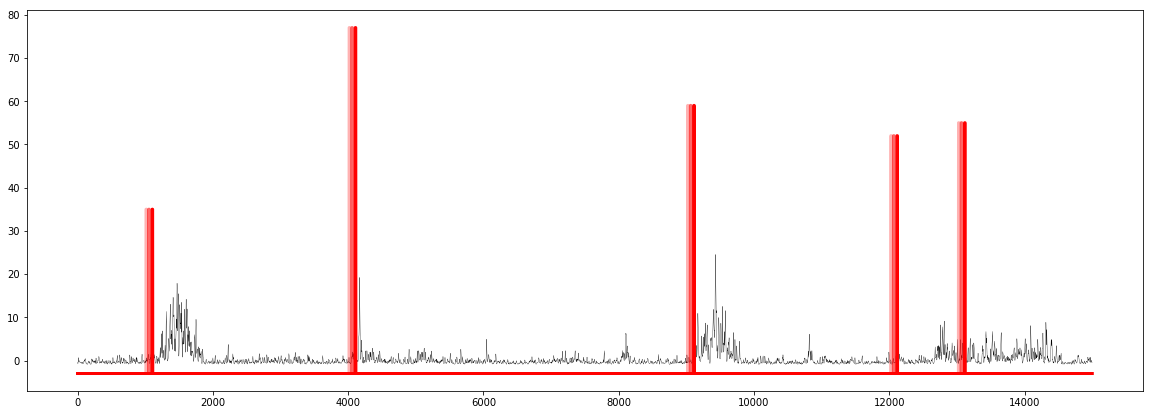

In [330]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = plt.plot(y[0:15000,60], 'k', linewidth=0.3)
ax = plt.plot(X[0:15000,10]-3, color = [1, 0, 0, 1], linewidth=3)
ax = plt.plot(X[0:15000,5]-3, color = [1, 0, 0, 0.6], linewidth=3)
ax = plt.plot(X[0:15000,1]-3, color = [1, 0, 0, 0.3], linewidth=3)

In [331]:
# Define the dependent variable
# Fit the model
est = make_pipeline(StandardScaler(), LinearRegression())
est.fit(X_all, y)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

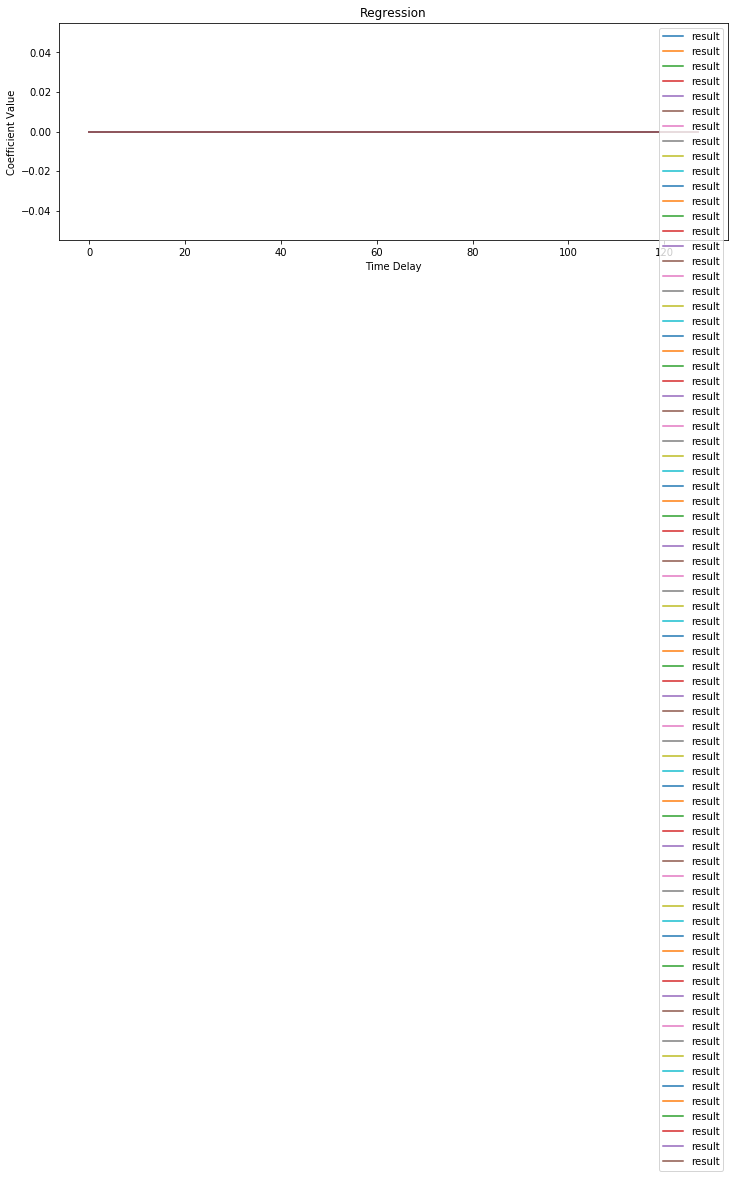

In [332]:
# Plot results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(est.steps[-1][-1].coef_, label = 'result')

ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regression')
ax.legend()

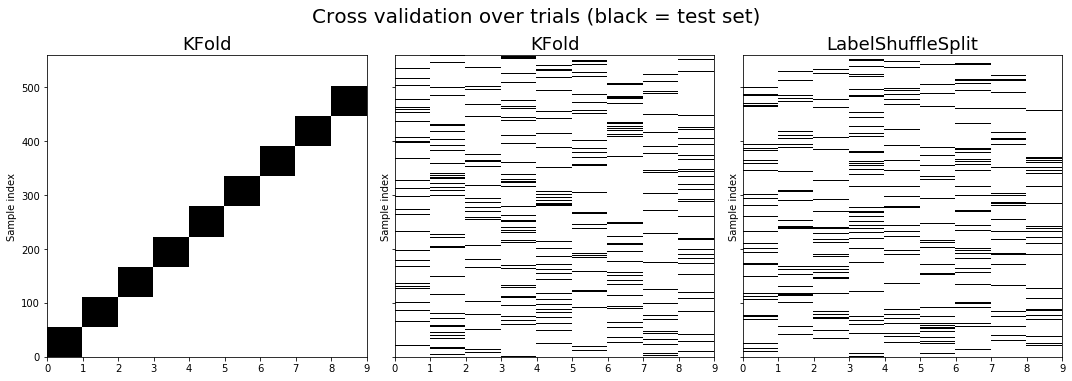

In [333]:
# Iterating across trials (labels)
n_cv_iterations = 10
trials = (np.unique(data.loc[:,'trial']))
cv_iterators = [cv.KFold(len(trials), n_folds=n_cv_iterations),
                cv.KFold(len(trials), n_folds=n_cv_iterations, shuffle=True),
                cv.LabelShuffleSplit(trials, n_iter=n_cv_iterations,
                                     test_size=.1)]

fig, axs = plt.subplots(1, len(cv_iterators), figsize=(15, 5),
                        sharey=True, sharex=True)
for ax, icv in zip(axs, cv_iterators):
    ax = plot_cv_indices(icv, ax)
    ax.set_title(type(icv).__name__, fontsize=18)
fig.suptitle('Cross validation over trials (black = test set)',
             fontsize=20, y=1.05)
plt.tight_layout()

In [334]:
len(np.unique(data.loc[:,'trial']))

560

In [335]:
# We'll use the KFold iterator, shuffling trial numbers first
cross_val_iterator = cv.KFold(len(trials), n_folds=5, shuffle=True)
model = Ridge(alpha=1e5)

In [336]:
cross_val_iterator

sklearn.cross_validation.KFold(n=560, n_folds=5, shuffle=True, random_state=None)

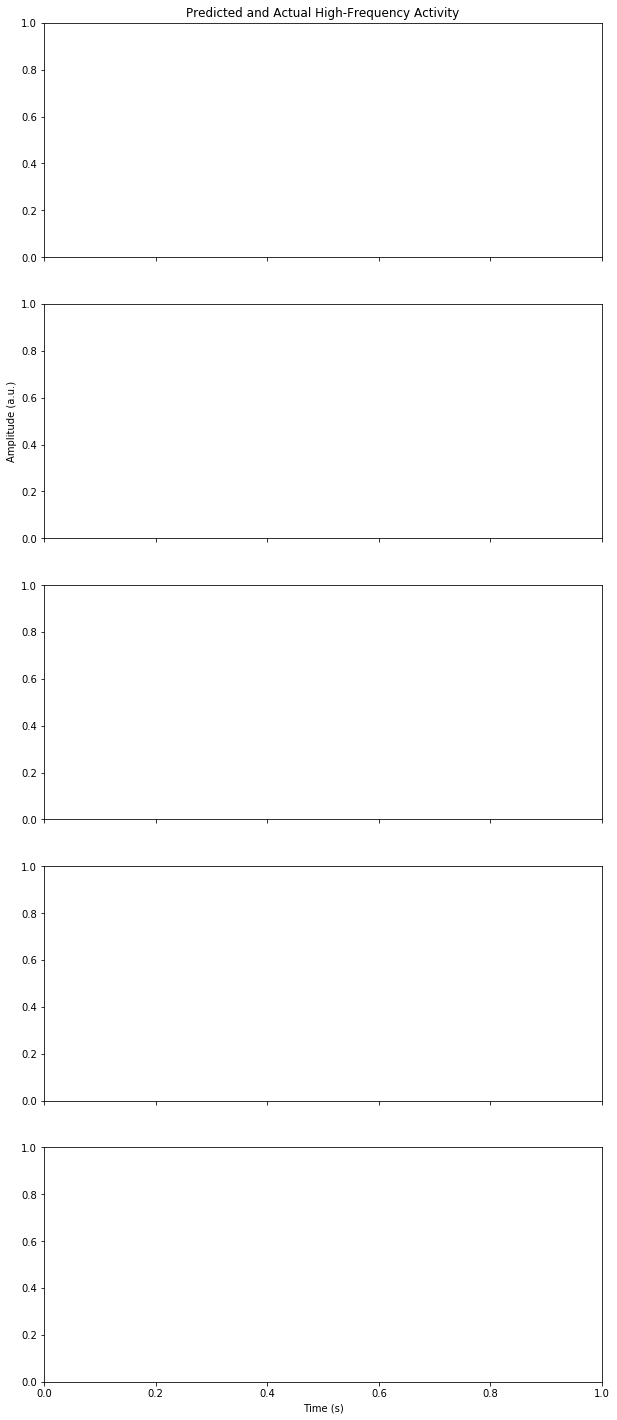

In [337]:
fig, axs = plt.subplots(len(cross_val_iterator), 1,
                        figsize=(10, 5*len(cross_val_iterator)),
                        sharex=True)
axs[0].set_title('Predicted and Actual High-Frequency Activity')
axs[1].set_ylabel('Amplitude (a.u.)')
axs[-1].set_xlabel('Time (s)')

scores_all = np.zeros([y.shape[1], cross_val_iterator.n_folds])
scores_cv = np.zeros(y.shape[1])

counter = 0
for ax, (tr, tt) in zip(axs, cross_val_iterator):
    # Pull the training / testing data for the ecog data
    y_tr = y[data['trials'].isin(tr)]    
    y_tt = y[data['trials'].isin(tt)]

    # Pull the training / testing data for the spectrogram
    X_tr = X[data['trials'].isin(tr)]    
    X_tt = X[data['trials'].isin(tt)]    

    # Scale all the features for simplicity
    X_tr = scale(X_tr)
    X_tt = scale(X_tt)
    y_tr = scale(y_tr)
    y_tt = scale(y_tt)

    # Fit the model, and use it to predict on new data
    model.fit(X_tr, y_tr)
    predictions = model.predict(X_tt)

    # Get the average (R2)
    # Get the average (R2)
    for i in range(0, y.shape[1]):
        scores_cv[i] = r2_score(y_tt[:,i], predictions[:,i])
    
    scores_all[:,counter] = scores_cv
    counter = counter + 1

In [338]:
scores_all = np.mean(scores_all, axis=1)

In [339]:
np.savetxt('/Volumes/LBCN8T_2/Stanford/data/encoding/57_scores.csv', scores_all, delimiter=',')

In [340]:
dir_data = '/Volumes/LBCN8T_2/Stanford/data/encoding/'

scores_all = []
for i in range(0,128):
    data = pd.read_csv(dir_data + 'data_' + str(i+1) + '.csv') 
    # Set extreme values to zero (double check spike exclusion)
    data.loc[data.loc[:,'HFB']>30, 'HFB'] = 0
    # Recode task name and organize data
    data.loc[data.loc[:,'task_general_cond_name']==4, 'task_general_cond_name'] = 2
    data.loc[data.loc[:,'task_general_cond_name']==6, 'task_general_cond_name'] = 1
    #data = data.loc[data.loc[:,'task_general_cond_name'] == 2,:]
    data = data.reset_index()
    
    # Correct trial count
    times = np.shape(np.unique(data.loc[:,'time']))
    times = int(times[0])
    r,c = np.shape(data)
    trials = int(r/times)
    trials_rs = np.matlib.repmat(np.arange(1,trials+1),times,1).T
    trials_rs = trials_rs.reshape(-1,1)
    data['trials'] = trials_rs

    # Define dependent variable
    y = np.array(data.loc[:,'HFB']) # HFB
    
    scores = []
    # Iterate through cross-validation splits
    for ax, (tr, tt) in zip(axs, cross_val_iterator):
        # Pull the training / testing data for the ecog data
        y_tr = y[data['trials'].isin(tr)]    
        y_tt = y[data['trials'].isin(tt)]

        # Pull the training / testing data for the spectrogram
        X_tr = X[data['trials'].isin(tr)]    
        X_tt = X[data['trials'].isin(tt)]    

        # Scale all the features for simplicity
        X_tr = scale(X_tr)
        X_tt = scale(X_tt)
        y_tr = scale(y_tr)
        y_tt = scale(y_tt)

        # Fit the model, and use it to predict on new data
        model.fit(X_tr, y_tr)
        predictions = model.predict(X_tt)

        # Get the average (R2)
        scores.append(r2_score(y_tt, predictions))

    scores_all.append(np.mean(scores))

FileNotFoundError: [Errno 2] File /Volumes/LBCN8T_2/Stanford/data/encoding/data_1.csv does not exist: '/Volumes/LBCN8T_2/Stanford/data/encoding/data_1.csv'

In [ ]:
scores_all = np.array(scores_all)

In [ ]:
yy_tr = np.stack((y_tr, y_tr), axis=-1)
yy_tt = np.stack((y_tt, y_tt), axis=-1)

In [ ]:
print(y_tr.shape)
print(X_tr.shape)
print(yy_tr.shape)


In [ ]:
model.fit(X_tr, yy_tr)
predictions = model.predict(X_tt)

In [ ]:
predictions.shape

In [ ]:
fig, axs = plt.subplots(len(cross_val_iterator), 1,
                        figsize=(10, 5*len(cross_val_iterator)),
                        sharex=True)
axs[0].set_title('Predicted and Actual High-Frequency Activity')
axs[1].set_ylabel('Amplitude (a.u.)')
axs[-1].set_xlabel('Time (s)')

scores_all = []


scores = []
# Iterate through cross-validation splits
for ax, (tr, tt) in zip(axs, cross_val_iterator):
    # Pull the training / testing data for the ecog data
    y_tr = y[data['trials'].isin(tr)]    
    y_tt = y[data['trials'].isin(tt)]

    # Pull the training / testing data for the spectrogram
    X_tr = X[data['trials'].isin(tr)]    
    X_tt = X[data['trials'].isin(tt)]    
    
    # Scale all the features for simplicity
    X_tr = scale(X_tr)
    X_tt = scale(X_tt)
    y_tr = scale(y_tr)
    y_tt = scale(y_tt)
    
    # Reshape since to 1D
#    X_tr = X_tr.reshape(-1,1)
#    X_tt = X_tt.reshape(-1,1)
#    y_tr = y_tr.reshape(-1,1)
#    y_tt = y_tt.reshape(-1,1)
    
    # Fit the model, and use it to predict on new data
    model.fit(X_tr, y_tr)
    predictions = model.predict(X_tt)
    
    # Plot the predicted and actual values.
    # We'll subtract the mean from each so it's easier to visualize
    ax.plot(scale(y_tt), color='k', alpha=.2, lw=2)
    ax.plot(scale(predictions), color='r', lw=2)
    ax.axis('tight')
    
    # Finally, plot the coefficient of determination (R2)
    print(r2_score(y_tt, predictions))
    scores.append(r2_score(y_tt, predictions))
_ = axs[0].legend(['Actual', 'Predicted'])

scores_all.append(np.mean(scores))

In [ ]:
scores_all[60]

In [ ]:
im = plt.imread('/Users/pinheirochagas/Pedro/Stanford/code/paper-encoding_decoding_electrophysiology copy/raw_data/brain.png')

In [ ]:
melec = pd.read_csv('/Users/pinheirochagas/Desktop/elec/meta_elec.csv')




In [ ]:
xy = melec[['x_2d', 'y_2d']].values

In [ ]:
ax = modelingtools.plot_activity_on_brain(scores_all, im, xy[:, 0], xy[:, 1],
                                          size_scale=3000, vmin=-.1, vmax=.1,
                                          cmap=modelingtools.cmap_score)
ax.figure.set_size_inches(10, 10)
ax.set_title('Prediction Scores ($R^2$)', fontsize=20)

In [ ]:
import modelingtools